<a href="https://colab.research.google.com/github/talhaanwarch/IDDs_EEG_ML_classification/blob/master/wavelet_features_Music.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.biorxiv.org/content/10.1101/759738v1.full.pdf  
https://www.sciencedirect.com/science/article/pii/S2352340920303826  
https://data.mendeley.com/datasets/fshy54ypyh/1  

In [1]:
!wget https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/fshy54ypyh-1.zip

--2020-06-17 15:21:45--  https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/fshy54ypyh-1.zip
Resolving md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com (md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com)... 52.218.100.32
Connecting to md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com (md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com)|52.218.100.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34220065 (33M) [application/octet-stream]
Saving to: ‘fshy54ypyh-1.zip’

fshy54ypyh-1.zip    100%[===================>]  32.63M  19.7MB/s    in 1.7s    

2020-06-17 15:21:47 (19.7 MB/s) - ‘fshy54ypyh-1.zip’ saved [34220065/34220065]



In [2]:
%%capture 
!unzip fshy54ypyh-1.zip

In [3]:
import scipy.io
from glob import glob
import numpy as np
from tqdm import tqdm


In [4]:
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score,accuracy_score
from sklearn.model_selection import KFold,LeaveOneOut,StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
import xgboost as xgb


In [5]:
IDD='/content/Data/Data/CleanData/Data/Data/CleanData/CleanData_IDD'
TDC='/content/Data/CleanData/CleanData_TDC'

In [6]:
!rm '/content/Data/Data/CleanData/Data/Data/CleanData/CleanData_IDD/Rest/NDS001_Rest_CD(1).mat'

In [7]:
IDD_rest=[]
for i in glob(IDD+'/Music/*.mat'):
    data=scipy.io.loadmat(i)['clean_data'].reshape(14,-1,128*4)
    data=np.swapaxes(data,0,1)
    IDD_rest.append(data )

TDC_rest=[]
for i in glob(TDC+'/Music/*.mat'):
    data=scipy.io.loadmat(i)['clean_data'].reshape(14,-1,128*4)
    data=np.swapaxes(data,0,1)
    TDC_rest.append(data )

In [8]:
# import pywt
# def wavelet_coefs(data, wavelet_name='db10'):
#     wavelet = pywt.Wavelet(wavelet_name)
#     levdec = min(pywt.dwt_max_level(data.shape[-1], wavelet.dec_len), 6)
#     coefs = pywt.wavedec(data, wavelet=wavelet, level=None)
#     n_channels, n_times = data.shape
#     levdec = len(coefs) - 1
#     wavelet_energy = np.zeros((n_channels, levdec))
#     for j in range(n_channels):
#         for l in range(levdec):
#             #wavelet_energy[j, l] = np.sum(coefs[levdec - l][j, :] ** 2)
#             wavelet_energy[j, l] = np.std(coefs[levdec - l][j, :])
#     return wavelet_energy.ravel()

In [9]:
import pywt

def wavelet_coefs(data, wavelet_name='db10'):
  coefs = pywt.wavedec(data, wavelet=wavelet_name, level=None)
  n_channels, n_times = data.shape
  levdec = len(coefs) - 1
  wavelet_energy = np.zeros((n_channels, levdec))
  for j in range(n_channels):
    for l in range(levdec):
      #wavelet_energy[j, l] = np.sum(coefs[levdec - l][j, :] ** 2)
      wavelet_energy[j, l] = np.mean(coefs[levdec - l][j, :])
  return wavelet_energy.ravel()

In [10]:
import warnings
warnings.filterwarnings("ignore")
features1=[]
features2=[]
for k in tqdm(range(7)):
  feature1=[]
  feature2=[]
  for i in range(30):  
    feature1.append(wavelet_coefs(IDD_rest[k][i]))
    feature2.append(wavelet_coefs(TDC_rest[k][i]))
  features1.append(np.array(feature1))
  features2.append(np.array(feature2))



100%|██████████| 7/7 [00:00<00:00, 14.99it/s]


In [11]:
x1=np.array(features1)        
x2=np.array(features2) 
print(x1.shape,x2.shape)

(7, 30, 56) (7, 30, 56)


In [12]:
X=np.concatenate((x1,x2),axis=0)

y=np.concatenate(((np.zeros(x1.shape[0])),(np.ones(x2.shape[0]))))
X.shape,y.shape

((14, 30, 56), (14,))

In [13]:
classifiers = [
    KNeighborsClassifier(),
    SVC(),
    NuSVC(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    #xgb.XGBClassifier(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression()]

In [14]:
accuracy_avg=[]
accuracy_std=[]
f1_avg=[]
f1_std=[]
for clfs in classifiers:
    # print('====================================')
    # name = clfs.__class__.__name__
    # print(name)
    acc_scores=[]
    f1_scores=[]
    for train,test in StratifiedKFold(7).split(X,y):
      X_train=X[train].reshape(-1,X.shape[2])
      X_test=X[test].reshape(-1,X.shape[2])
      y_train=np.concatenate([[i]*X.shape[1] for i in y[train]])
      y_test=np.concatenate([[i]*X.shape[1] for i in y[test]])
      sc=StandardScaler()
      X_train=sc.fit_transform(X_train)
      X_test=sc.transform(X_test)
      X_train, y_train = shuffle(X_train, y_train)
      
      clfs.fit(X_train,y_train)
      y_pred=clfs.predict(X_test)
      acc_scores.append(accuracy_score(y_test,y_pred))
      f1_scores.append(f1_score(y_test,y_pred))
    accuracy_avg.append(np.mean(acc_scores))
    accuracy_std.append(np.std(acc_scores))
    f1_avg.append(np.mean(f1_scores))
    f1_std.append(np.std(f1_scores))

Text(0.5, 1.0, 'Classifiers Accuracy')

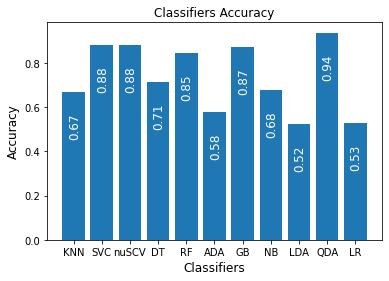

In [15]:
import matplotlib.pyplot as plt
classifier=['KNN','SVC','nuSCV','DT','RF','ADA','GB','NB','LDA','QDA','LR']
y_pos = np.arange(len(classifier))
plt.bar(y_pos,np.array(accuracy_avg))
ys=np.array(accuracy_avg)
for index, value in enumerate(ys):
    plt.text(index-0.2,value-0.2, str(np.round(value,2)),rotation=90,color='white',fontsize=12)
plt.xticks(y_pos, classifier)
plt.ylabel('Accuracy',fontsize=12)
plt.xlabel('Classifiers',fontsize=12)
plt.title('Classifiers Accuracy',fontsize=12)


Text(0.5, 1.0, 'Classifiers F1-Score')

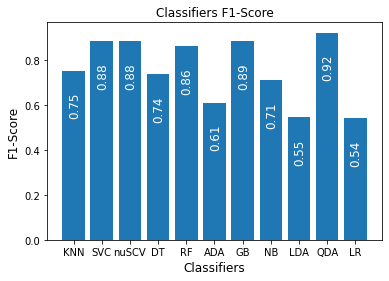

In [16]:
import matplotlib.pyplot as plt
classifier=['KNN','SVC','nuSCV','DT','RF','ADA','GB','NB','LDA','QDA','LR']
y_pos = np.arange(len(classifier))
#plt.bar(y_pos,np.array(f1_avg),yerr=np.array(f1_std))
plt.bar(y_pos,np.array(f1_avg))
ys=np.array(f1_avg)
for index, value in enumerate(ys):
    plt.text(index-0.2,value-0.2, str(np.round(value,2)),rotation=90,color='white',fontsize=12)
plt.xticks(y_pos, classifier)
plt.ylabel('F1-Score',fontsize=12)
plt.xlabel('Classifiers',fontsize=12)
plt.title('Classifiers F1-Score',fontsize=12)